In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [185]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [186]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [187]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [188]:
TESTID = test['Id']

In [189]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000,842206.000000,575773.000000,575773.000000,844392.000000,421085.000000,421085.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580,5457.979627,7.224879,2008.697747,0.498684,23.253426,2011.754019
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103,7809.437311,3.210144,5.978048,0.499999,14.100569,1.660962
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000,710.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,2320.000000,8.000000,2010.000000,0.000000,22.000000,2012.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000,6890.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


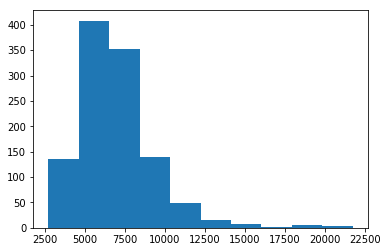

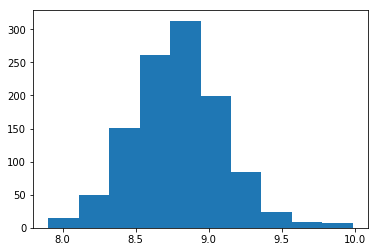

In [190]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [191]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [192]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        #data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        #data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [193]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

Index(['DayOfWeek', 'Sales', 'Promo', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
Index(['DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


In [194]:
# ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
# import seaborn as sns
# sns.barplot(ST_gp.index,ST_gp.values)
# plt.show()
# StateOPen_gp = train.groupby(['StateHoliday','SchoolHoliday'])['Sales'].agg('mean')
# sns.barplot(StateOPen_gp.index,StateOPen_gp.values)
# plt.show()
# As_gp = train.groupby('Assortment')['Sales'].agg('mean')
# sns.barplot(As_gp.index,As_gp.values)
# plt.show()
# Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
# ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
# plt.tight_layout()
# plt.show()

# #每年销售额的趋势
# YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
# ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
# plt.tight_layout()
# plt.show()

In [195]:
# from sklearn.ensemble import GradientBoostingRegressor
# print(train.size)
# train.dropna(axis=0,how='any',inplace=True)
# print(train.size)

In [196]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

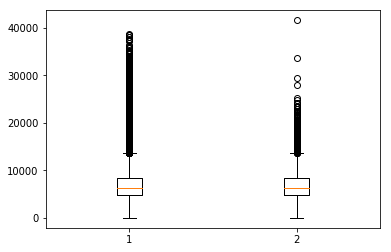

In [197]:
plt.boxplot([Y_train,Y_valid])
plt.show()

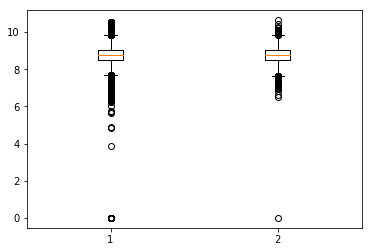

In [198]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [199]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

epohs = 20

In [200]:
params = {"objective": "reg:linear",
          "eta": 0.15,
          "max_depth": 12,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

dtrain = xgb.DMatrix(X_train, Y_train)
dvalid = xgb.DMatrix(X_valid, Y_valid)
dtest = xgb.DMatrix(test)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)

[0]	eval-rmse:7.02672	train-rmse:7.03115	eval-rmspe:0.999145	train-rmspe:0.999166
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:5.97551	train-rmse:5.97944	eval-rmspe:0.99734	train-rmspe:0.997367
[2]	eval-rmse:5.08254	train-rmse:5.08593	eval-rmspe:0.993355	train-rmspe:0.993393
[3]	eval-rmse:4.32332	train-rmse:4.32632	eval-rmspe:0.985788	train-rmspe:0.98584
[4]	eval-rmse:3.67899	train-rmse:3.68144	eval-rmspe:0.972914	train-rmspe:0.97298
[5]	eval-rmse:3.13112	train-rmse:3.13355	eval-rmspe:0.953295	train-rmspe:0.953399
[6]	eval-rmse:2.66612	train-rmse:2.66825	eval-rmspe:0.925861	train-rmspe:0.926002
[7]	eval-rmse:2.27184	train-rmse:2.27372	eval-rmspe:0.890154	train-rmspe:0.890378
[8]	eval-rmse:1.93766	train-rmse:1.93917	eval-rmspe:0.846786	train-rmspe:0.847144
[9]	eval-rmse:1.65322	train-rmse:1.65429	eval-rmspe:0.797322	train-rmspe:0.7979
[10]	eval-rmse:1.4122	train-rmse:1.412

[96]	eval-rmse:0.147707	train-rmse:0.128033	eval-rmspe:0.132306	train-rmspe:0.143471
[97]	eval-rmse:0.14709	train-rmse:0.12733	eval-rmspe:0.131473	train-rmspe:0.142812
[98]	eval-rmse:0.146995	train-rmse:0.127202	eval-rmspe:0.131363	train-rmspe:0.14268
[99]	eval-rmse:0.146827	train-rmse:0.126749	eval-rmspe:0.131036	train-rmspe:0.142019
[100]	eval-rmse:0.146258	train-rmse:0.126062	eval-rmspe:0.130403	train-rmspe:0.141304
[101]	eval-rmse:0.146086	train-rmse:0.125597	eval-rmspe:0.130268	train-rmspe:0.140785
[102]	eval-rmse:0.14579	train-rmse:0.125209	eval-rmspe:0.129929	train-rmspe:0.140151
[103]	eval-rmse:0.145523	train-rmse:0.124799	eval-rmspe:0.129582	train-rmspe:0.13974
[104]	eval-rmse:0.145251	train-rmse:0.124399	eval-rmspe:0.129318	train-rmspe:0.139366
[105]	eval-rmse:0.144953	train-rmse:0.123959	eval-rmspe:0.128878	train-rmspe:0.138944
[106]	eval-rmse:0.144639	train-rmse:0.123625	eval-rmspe:0.128473	train-rmspe:0.138614
[107]	eval-rmse:0.144565	train-rmse:0.12342	eval-rmspe:0.128351

[192]	eval-rmse:0.136266	train-rmse:0.104289	eval-rmspe:0.118542	train-rmspe:0.114015
[193]	eval-rmse:0.136242	train-rmse:0.104097	eval-rmspe:0.118492	train-rmspe:0.113693
[194]	eval-rmse:0.136161	train-rmse:0.103939	eval-rmspe:0.118401	train-rmspe:0.113571
[195]	eval-rmse:0.136153	train-rmse:0.103835	eval-rmspe:0.118348	train-rmspe:0.113447
[196]	eval-rmse:0.136047	train-rmse:0.103622	eval-rmspe:0.118208	train-rmspe:0.113146
[197]	eval-rmse:0.135996	train-rmse:0.103446	eval-rmspe:0.118107	train-rmspe:0.112976
[198]	eval-rmse:0.136005	train-rmse:0.103269	eval-rmspe:0.118056	train-rmspe:0.112774
[199]	eval-rmse:0.135971	train-rmse:0.103161	eval-rmspe:0.118026	train-rmspe:0.112688
[200]	eval-rmse:0.135946	train-rmse:0.103028	eval-rmspe:0.117848	train-rmspe:0.112541
[201]	eval-rmse:0.135923	train-rmse:0.102913	eval-rmspe:0.117773	train-rmspe:0.112395
[202]	eval-rmse:0.135875	train-rmse:0.102776	eval-rmspe:0.117741	train-rmspe:0.112223
[203]	eval-rmse:0.135798	train-rmse:0.102663	eval-rmsp

[288]	eval-rmse:0.133964	train-rmse:0.092567	eval-rmspe:0.114521	train-rmspe:0.100313
[289]	eval-rmse:0.133966	train-rmse:0.092494	eval-rmspe:0.114532	train-rmspe:0.10025
[290]	eval-rmse:0.133908	train-rmse:0.092456	eval-rmspe:0.114512	train-rmspe:0.100237
[291]	eval-rmse:0.133884	train-rmse:0.092378	eval-rmspe:0.11449	train-rmspe:0.100175
[292]	eval-rmse:0.13386	train-rmse:0.092318	eval-rmspe:0.114417	train-rmspe:0.09995
[293]	eval-rmse:0.133827	train-rmse:0.092165	eval-rmspe:0.114354	train-rmspe:0.099624
[294]	eval-rmse:0.133791	train-rmse:0.092057	eval-rmspe:0.114323	train-rmspe:0.099141
[295]	eval-rmse:0.133714	train-rmse:0.091921	eval-rmspe:0.114277	train-rmspe:0.09896
[296]	eval-rmse:0.133724	train-rmse:0.091834	eval-rmspe:0.114398	train-rmspe:0.098926
[297]	eval-rmse:0.133746	train-rmse:0.09177	eval-rmspe:0.114433	train-rmspe:0.098863
[298]	eval-rmse:0.133779	train-rmse:0.091662	eval-rmspe:0.114416	train-rmspe:0.098987
[299]	eval-rmse:0.133795	train-rmse:0.091598	eval-rmspe:0.11

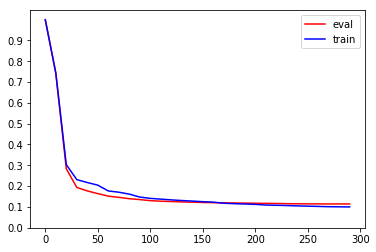

In [201]:
evaldata = ret['eval']['rmspe'][0:300:10]
traindata = ret['train']['rmspe'][0:300:10]
plt.plot(range(0,300,10),evaldata,color='red',label="eval")
plt.plot(range(0,300,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()

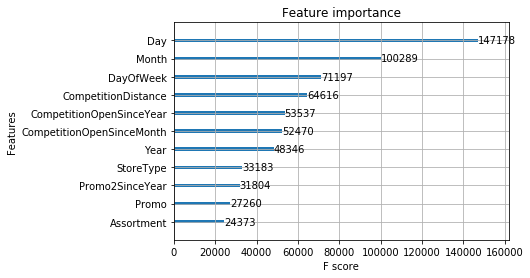

In [205]:
#从最终的训练importnace中看果然是时间序列影响比较大
xgb.plot_importance(gbm)

In [206]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = gbm.predict(dtest)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [207]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)